In [116]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from datetime import datetime
import scipy.stats
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,f1_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")
from tqdm import tqdm
from statsmodels.tsa.ar_model import AutoReg,AR
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
import json
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
import pymc3 as pm
from pymc3.stats import mcse
import arviz as az
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder


In [117]:
def check_adf(column):# return p value
    adf_result=adfuller(column)
    if adf_result[1]<=0.05:
        return 'Stationary'
    else:
        return 'Non-Stationary'
    

def get_diff_order(column):
  if check_adf(column)=='Non-Stationary':
    column=column.diff().dropna()
    if check_adf(column)=='Non-Stationary':
        diff_order=2
        column=column.diff().dropna()
    else:
        diff_order=1
  else:
    diff_order=0
  return column,diff_order

def find_Feature_lag(df,target,maxlag,diff_order,p):
    df_sample=df.copy()
    best_aic = np.inf
    best_lag = None
    max_lag=maxlag
    for i in range(1,max_lag+1):
        df_sample[target]=df_sample[target].shift(i)
        df_c=df_sample.dropna()
        model=SARIMAX(df_c[['unweighted_ili']],df_c[target],order=(p,diff_order,0))
        results=model.fit()
        if results.aic<best_aic and results.aic>0:
            best_aic=results.aic 
            best_lag=i
        if best_aic<0 or not best_lag:
            best_lag=2
    return best_lag

def _create_lags(data,maxlag,target,lag=None):
    datax=data.copy()
    for i in datax.columns:
        if i!='state':
          if lag:
            best_lag_value=lag
          #else:
            #best_lag_value=find_Feature_lag(data,i,maxlag,diff_order,p)
          datax[i + "_lag" + str(best_lag_value)]=datax[i].shift(best_lag_value)
          if i!=target:
            datax=datax.drop(i,axis='columns')
    return datax
def best_ili_lag(df,maxlag,diff_order):
    best_aic = np.inf
    best_lag = None
    max_lag=maxlag
    for i in range(1,max_lag+1):
        model=ARIMA(df[['unweighted_ili']],order=(i,1,0))
        results=model.fit()
        if results.aic<best_aic and results.aic>0:
            best_aic=results.aic 
            best_lag=i
        if best_aic<0 or not best_lag:
            best_lag=2
        return best_lag

In [118]:
df=pd.read_csv('/kaggle/input/lab-positive-national-pca/pca_1_national_lab_Positive_dff.csv')
df['date']=pd.to_datetime(df['date'])
df1=(df.set_index('date',drop=True))
states=df1['state'].unique()
df1['school_mode'] = df1['school_mode'].round().astype(int)
df1['elderly_mode'] = df1['elderly_mode'].round().astype(int)
ordinal_encoder = OrdinalEncoder()
ordinal_encoded_values = ordinal_encoder.fit_transform(df1[['school_mode', 'elderly_mode']])
df1[['school_mode', 'elderly_mode']] = ordinal_encoded_values
print(df1.shape)
df1.head(10)

(4823, 12)


,state,elderly_mode,school_mode,unweighted_ili,mask,rr_av7,gp_av7,transit_av7,work_av7,resid_av7,percent_positive,pca_1
date,,,,,,,,,,,,
2020-03-01,AL,0.0,0.0,6.32549,0.0000,12.857143,7.285714,10.285714,2.285714,-1.000000,10.63,38.948903
2020-03-01,AK,0.0,0.0,3.70284,0.0000,11.571429,8.142857,8.857143,3.571429,-0.857143,27.59,37.830148
2020-03-01,AZ,0.0,0.0,2.31816,0.0615,8.428571,6.000000,6.428571,2.571429,-1.000000,12.47,33.605559
2020-03-01,AR,0.0,0.0,4.90157,0.0000,17.142857,10.000000,5.857143,3.285714,-2.142857,44.27,38.662304
2020-03-01,CA,0.0,0.0,3.99147,0.1583,5.142857,5.000000,0.857143,2.428571,-0.714286,20.06,27.370773
2020-03-01,CO,0.0,0.0,5.82979,0.1030,6.714286,7.714286,2.428571,3.571429,-0.857143,18.45,30.466948
2020-03-01,CT,0.0,0.0,6.19415,0.0000,6.428571,4.571429,4.714286,2.857143,-0.857143,17.59,30.974179
2020-03-01,DE,0.0,0.0,2.46723,0.0000,9.714286,4.428571,4.285714,3.142857,-0.857143,14.50,32.150367
2020-03-01,GA,0.0,0.0,5.44455,0.0001,8.857143,5.142857,4.428571,1.857143,-1.000000,13.52,31.779436


In [119]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4823 entries, 2020-03-01 to 2022-06-26
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   state             4823 non-null   object 
 1   elderly_mode      4823 non-null   float64
 2   school_mode       4823 non-null   float64
 3   unweighted_ili    4823 non-null   float64
 4   mask              4823 non-null   float64
 5   rr_av7            4823 non-null   float64
 6   gp_av7            4823 non-null   float64
 7   transit_av7       4823 non-null   float64
 8   work_av7          4823 non-null   float64
 9   resid_av7         4823 non-null   float64
 10  percent_positive  4823 non-null   float64
 11  pca_1             4823 non-null   float64
dtypes: float64(11), object(1)
memory usage: 489.8+ KB


In [120]:
def clean(dataframe):
  Q1 = dataframe['unweighted_ili'].quantile(0.25)
  Q3 = dataframe['unweighted_ili'].quantile(0.75)
  IQR = Q3 - Q1
  median = dataframe['unweighted_ili'].median()
  dataframe = dataframe[(dataframe['unweighted_ili'] >0) & (dataframe['unweighted_ili'] <= median + 1.5*IQR)]
  return dataframe
def return_state_data(data,state,lagg,start_date,end_date,cols):
  df1_st=data[data['state']==state][start_date:end_date]
  df2_st=df1_st[cols]
  data_new=_create_lags(data=df2_st.dropna(),maxlag=4,target='percent_positive',lag=lagg)# p wnt work here, as i have put lagg even for ili-lagg
  df_c1=data_new.dropna()
  return df_c1

In [232]:
class Model:
    def __init__(self, county_idxs, new_dat_mat, coords,categorical=True):
        self.county_idxs = county_idxs
        self.new_dat_mat = new_dat_mat
        self.coords = coords
        self.model = None
        self.trace = None
        if categorical:
            self.categorical=categorical
        self.categorical_school=new_dat_mat[:,2]
        self.categorical_elderly=new_dat_mat[:,1]
        self.school_mode_values = np.unique(self.categorical_school)
        self.school_mode_idx = np.searchsorted(self.school_mode_values , self.categorical_school)
        self.elderly_mode_values = np.unique(self.categorical_elderly)
        self.elderly_mode_idx = np.searchsorted(self.elderly_mode_values, self.categorical_elderly)
    def build_model(self,model_distribution):
        with pm.Model(coords=self.coords) as hierarchical_model:
            #PRIORS
            b_pca_= pm.Normal('b_pca_', mu=0., sigma=1)
            b_masking= pm.Normal('b_masking', mu=0., sigma=1)
            if  hasattr(self, 'categorical') and self.categorical:
                b_school= pm.Normal('b_school', mu=0., sigma=1,dims='school_mode' )
                school_category = pm.Data('school_mode', self.categorical_school, dims='obs_id')
                b_elderly= pm.Normal('b_elderly', mu=0., sigma=1,dims='elderly_mode')
                elderly_category = pm.Data('elderly_mode', self.categorical_elderly, dims='obs_id')
            else:
                b_school= pm.Normal('b_school', mu=0., sigma=1)
                b_elderly= pm.Normal('b_elderly', mu=0., sigma=1)
            mu_a = pm.Normal('mu_a', mu=0., sigma=1)
            sigma_a = pm.HalfCauchy('sigma_a', beta=1)

            #hierarchical part
            county_idx = pm.Data("county_idx",self.county_idxs , dims="obs_id")
            floor = pm.Data("floor", self.new_dat_mat[:,0], dims="obs_id")
            b_ili_lag = pm.Normal(f'ili_lag_{county_idx}', mu=0, sigma=1,dims="county")
            a = pm.Normal(f'alpha_{county_idx}', mu=mu_a, sigma=sigma_a,dims="county")
            if hasattr(self, 'categorical') and self.categorical:
                formula= (a[county_idx] + b_ili_lag[county_idx]*self.new_dat_mat[:,3] + b_masking*self.new_dat_mat[:,4]+
                b_school[self.school_mode_idx]*self.new_dat_mat[:,2] + b_elderly[self.elderly_mode_idx]*self.new_dat_mat[:,1]+b_pca_*self.new_dat_mat[:,5])
            else:
                formula= (a[county_idx] + b_ili_lag[county_idx]*self.new_dat_mat[:,3] + b_masking*self.new_dat_mat[:,4]+
                         b_school*self.new_dat_mat[:,2] + b_elderly*self.new_dat_mat[:,1]+b_pca_*self.new_dat_mat[:,5])
            eps = pm.HalfCauchy("eps", 1)
            if model_distribution=='Poisson':
                pm.Poisson(f'y_like_{county_idx}', mu=np.exp(formula), observed=floor)
            elif model_distribution=='Normal':
                pm.Normal(f'y_like_{county_idx}', mu=formula,sigma=eps,observed=floor) 
    
            self.model = hierarchical_model

    def fit_model(self,model_distribution, draws=5000, step=None):
        if self.model is None:
            self.build_model(model_distribution)

        with self.model:
            if step=='Metropolis':
                self.trace = pm.sample(draws=draws, step=pm.Metropolis())
            elif step=='Nuts':
                self.trace=pm.sample(draws=draws)
        return self.trace,self.model

    def plot_trace(self,cols):
        if self.trace is None:
            raise ValueError("Trace is not available. You need to fit the model first.")

        az.plot_posterior(self.trace, var_names=cols,kind='hist')
    def get_posteriors(self):
        return pm.sample_posterior_predictive(self.trace, model=self.model)
    def get_waic(self):
        waic=pm.waic(self.trace, self.model)
        return round(waic.waic,3)
    def get_summary(self):
        return pm.summary(self.trace)[['mean','sd','hdi_3%','hdi_97%']]


In [178]:
def transformed_data(dataframe,lagg,no_of_columns,start_date,end_date,cols): 
    dat_mat = np.zeros((len(states)*100,no_of_columns+1))
    state_idx=1
    for state in states: 
        if state not in ['AK','DE','NV','WY']: 
            tmp = return_state_data(dataframe,state,lagg,start_date,end_date,cols).to_numpy()
            tmp = np.concatenate((tmp,np.repeat(state_idx,tmp.shape[0]).reshape((-1,1))),axis=1)
            dat_mat = np.append(dat_mat,tmp,axis=0)

            state_idx += 1
    new_dat_mat = dat_mat[dat_mat[:, no_of_columns] != 0]

    county_idxs, counties = pd.factorize(new_dat_mat[:,no_of_columns])
    n_school_modes = len(np.unique(new_dat_mat[:, 2]))
    n_elderly_modes = len(np.unique(new_dat_mat[:, 1]))
    coords = {
        "county": counties,
        "obs_id": range(new_dat_mat.shape[0]),
        "school_mode":np.arange(0,4),
        "elderly_mode":np.arange(0,4)
    }
    return new_dat_mat,coords,county_idxs

In [77]:
from pymc3.stats import mcse
def get_summary(trace,var_names= [ 'b_masking', 'b_school[0]','b_school[1]','b_school[2]','b_school[3]'
                                  'b_pca_', 'b_elderly[0]','b_elderly[1]','b_elderly[2]','b_elderly[3]', 'mu_a', 'sigma_a']):
    var_names = var_names
    summary_df = pd.DataFrame(columns=['Variable', 'Mean', 'SD', 'hpd_2.5%', 'hpd_97.5%', 
                                       'standarderror_mean', 'standarderror_sd'])
    hpd = {}
    for var_name in var_names:
        var_samples = trace[var_name]
        sorted_samples = np.sort(var_samples)
        n_samples = len(var_samples)
        ci_idx = int(0.025 * n_samples)
        hpd[var_name] = (sorted_samples[ci_idx], sorted_samples[-ci_idx])

    # Add mu and sigma_a
    for var_name in var_names:
        var_mean = np.mean(trace[var_name])
        var_sd = np.std(trace[var_name])
        var_hpd = hpd[var_name]
        var_mcse_mean = mcse(trace[var_name]).mean()
        var_mcse_sd = mcse(trace[var_name]).std()
        summary_df = summary_df.append({'Variable': var_name, 'Mean': round(var_mean,2), 'SD': var_sd,
                                         'hpd_2.5%': round(var_hpd[0],2), 'hpd_97.5%': round(var_hpd[1],2),
                                         'standarderror_mean': var_mcse_mean, 'standarderror_sd': var_mcse_sd},
                                         ignore_index=True)
    return summary_df

In [233]:
df_summary = pd.DataFrame()

for i in range(1,2):
    new_dat_mat, coords, county_idxs = transformed_data(dataframe=df1, lagg=i, no_of_columns=6,
                                                         start_date='2020-03-01', end_date='2022-06-26',
                                                         cols=['elderly_mode', 'school_mode', 'percent_positive', 'mask', 'pca_1'])
    model = Model(county_idxs, new_dat_mat, coords,categorical=True)    
    trace,model_graph= model.fit_model(model_distribution='Poisson', draws=10, step='Metropolis')
    waic = model.get_waic()
    summary = model.get_summary()
    summary['lag'] = i
    summary['waic'] = waic
    df_summary = pd.concat([df_summary, summary])


In [212]:
df_summary1=df_summary.reset_index()
df_summary2=df_summary1.rename(columns={'index':'Variable'})
df_summary2['lag'] = df_summary2['lag'].astype(str)

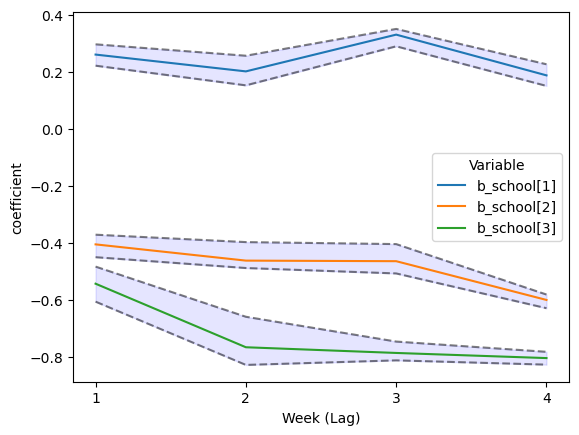

In [214]:
#['b_pca_','b_masking','b_school[0]','b_school[1]','b_school[2]','b_school[3]',
                    #'b_elderly[0]','b_elderly[1]','b_elderly[2]','b_elderly[3]']
var_to_plot=['b_school[1]','b_school[2]','b_school[3]']
fig, ax = plt.subplots()

for variable, group in df_summary2.groupby('Variable'):
    if variable  in var_to_plot:
        ax.plot(group['lag'], group['mean'], label=variable)
for variable, group in df_summary2.groupby('Variable'):
    if variable in var_to_plot:
        ax.fill_between(group['lag'], group['hdi_3%'], group['hdi_97%'], alpha=0.1, color='blue')
        ax.plot(group['lag'], group['hdi_3%'], '--', color='black', alpha=0.5)
        ax.plot(group['lag'], group['hdi_97%'], '--', color='black', alpha=0.5)

ax.set_xlabel('Week (Lag)')
ax.set_ylabel('coefficient')
ax.legend(title='Variable')
plt.show()


In [252]:
df_summary['waic'].unique()

array([ -7520.972,  -8255.424,  -9114.917,  -9297.947,  -9637.551,
        -9943.917, -10064.63 , -10179.422, -10224.239, -10305.847,
       -10285.621, -10234.789, -10191.789, -10916.257,  -9873.917,
        -9720.094,  -9519.224,  -9366.553,  -9191.037,  -8985.423,
        -8873.107,  -8708.341,  -8602.874,  -8506.391])

In [117]:
accuracies=[]
pred=ppc['y_like_county_idx']
print(pred.shape)
for i in range(1,51):
    state_idxs = np.where(new_dat_mat[:, 6] == i)[0]
    state_preds = pred[:, state_idxs]
    mean_pred=state_preds.mean(axis=0)
    observed=new_dat_mat[new_dat_mat[:, 6] == i,0]
    if len(observed)>0:
        r2 = r2_score(observed, mean_pred)
        accuracies.append(r2)
        print(f"Accuracy for index {i}: {r2}")
print(f"Average accuracy: {np.mean(accuracies)}")

(20000, 4728)
Accuracy for index 1: 0.5300046802068294
Accuracy for index 2: 0.7870244325090037
Accuracy for index 3: 0.9273548235401738
Accuracy for index 4: 0.8610467058616497
Accuracy for index 5: 0.9240413656015334
Accuracy for index 6: 0.4773725148373723
Accuracy for index 7: 0.7334169728935847
Accuracy for index 8: 0.9229374059830655
Accuracy for index 9: 0.8979747954101769
Accuracy for index 10: 0.8026066476556808
Accuracy for index 11: 0.4413420156305877
Accuracy for index 12: 0.9016321294007423
Accuracy for index 13: 0.4353345514950613
Accuracy for index 14: 0.8083356075905243
Accuracy for index 15: 0.7816694352805015
Accuracy for index 16: 0.8932098697783466
Accuracy for index 17: 0.8375718808500512
Accuracy for index 18: 0.9373636734850305
Accuracy for index 19: 0.9194027267348333
Accuracy for index 20: 0.7901692735786559
Accuracy for index 21: 0.9071482990548067
Accuracy for index 22: 0.8114626451073468
Accuracy for index 23: 0.7010372697182374
Accuracy for index 24: 0.9693

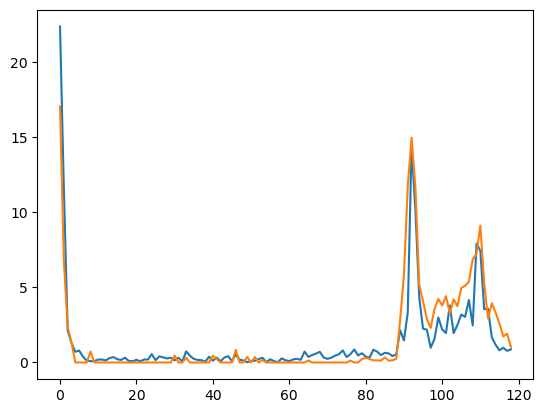

In [118]:
idx=20
state_idxs = np.where(new_dat_mat[:, 6] == idx)[0]
state_preds = pred[:, state_idxs]
mean_pred=state_preds.mean(axis=0)
observed=new_dat_mat[new_dat_mat[:, 6] == idx,0]
plt.plot(mean_pred)
plt.plot(observed)

In [125]:
var_names = [ 'b_masking', 'b_school','b_pca_', 'b_elderly', 'mu_a', 'sigma_a']
summary_df = pd.DataFrame(columns=['Variable', 'Mean', 'SD', 'hpd_2.5%', 'hpd_97.5%', 
                                   'standarderror_mean', 'standarderror_sd'])
hpd = {}
for var_name in var_names:
    var_samples = trace[var_name]
    sorted_samples = np.sort(var_samples)
    n_samples = len(var_samples)
    ci_idx = int(0.025 * n_samples)
    hpd[var_name] = (sorted_samples[ci_idx], sorted_samples[-ci_idx])
from pymc3.stats import mcse

# Add mu and sigma_a
for var_name in var_names:
    var_mean = np.mean(trace[var_name])
    var_sd = np.std(trace[var_name])
    var_hpd = hpd[var_name]
    var_mcse_mean = mcse(trace[var_name]).mean()
    var_mcse_sd = mcse(trace[var_name]).std()
    summary_df = summary_df.append({'Variable': var_name, 'Mean': round(var_mean,2), 'SD': var_sd,
                                     'hpd_2.5%': round(var_hpd[0],2), 'hpd_97.5%': round(var_hpd[1],2),
                                     'standarderror_mean': var_mcse_mean, 'standarderror_sd': var_mcse_sd},
                                     ignore_index=True)


# Display results
summary_df

TypeError: 'NoneType' object is not subscriptable

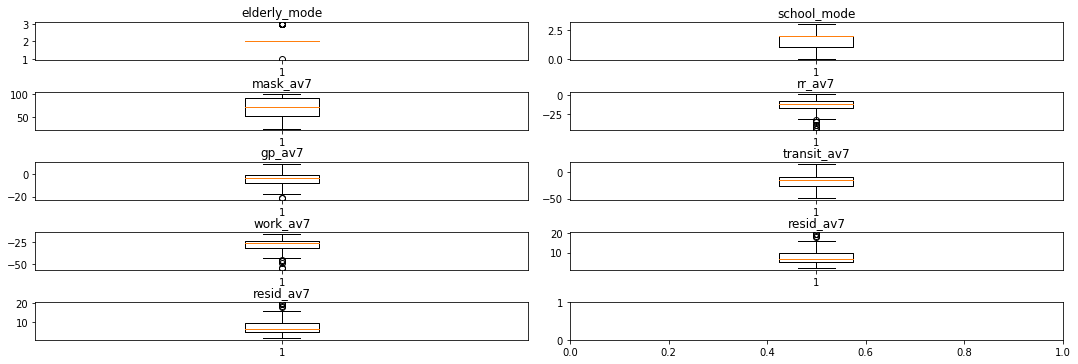

In [ ]:
"""def visualize_all_columns(df,ili):
    nrow=5
    ncol=2
    i=0
    fig, axes = plt.subplots(nrow, ncol,figsize=(15,15))
    fig.tight_layout()
    for r in range(nrow):
        for c in range(ncol):
            c1=ili
            c2=df[df.columns[i]]
            corr=round(c1.corr(c2),2)
            axes[r,c].plot(c1,label='il')
            axes[r,c].legend(['{:.2f}'.format(corr)],
                    loc = 'upper left',fontsize=20)
            ax2=axes[r,c].twinx()
            ax2.plot(c2,color='red',label=df.columns[i])
            ax2.legend()
            if i==len(df.columns)-1:
                break
            i+=1

def visualize_all_columns_outliers(df):
    nrow=5
    ncol=2
    i=0
    fig, axes = plt.subplots(nrow, ncol,figsize=(15,5))
    fig.tight_layout()
    for r in range(nrow):
        for c in range(ncol):
            axes[r,c].boxplot(df[df.columns[i]])
            axes[r,c].set_title(df.columns[i])
            if i==len(df.columns)-1:
                break
            i+=1
visualize_all_columns_outliers(df2_tx)"""